# Survival Analysis with Simulated Dataset

This notebook explores parameter estimation in survival models using synthetic data and Stochastic Gradient Descent (SGD).

**Models used:**
- Cox Proportional Hazards (via `lifelines`)
- Log-Normal AFT (via `pycox`)

**Main libraries:** pycox, lifelines, torchtuples, pandas, numpy, matplotlib, sklearn


In [ ]:
!pip install pycox
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.3/93.3 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 60.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.0/139.0 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 29.0 MB/s eta 0:00:00
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2435 sha256=0ce479f76462a0d2b666e1e3dec3b18ddbc3cf1d83ffd7a20b7a75c00cf1b071
  Stored in directory: /root/.cache/pip/wheels/a6/ff/5d/4f10de26fe5ddef243c97f13c6cf579d

In [ ]:
!pip install --upgrade pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 47.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


### 🧪 Load Dataset

We use the `flchain` dataset from the `pycox.datasets` module, which contains data on serum free light chain levels and survival times. This dataset is often used for benchmarking survival models.


In [ ]:
# Load Dataset
from pycox import datasets
data = datasets.flchain
data

In [ ]:
data = data.read_df(processed=False)

Dataset 'flchain' not locally available. Downloading...
Done


In [ ]:
data

,rownames,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,chapter,futime,death
0,1,97,F,1997,5.700,4.860,10,1.7,0,Circulatory,85,1
1,2,92,F,2000,0.870,0.683,1,0.9,0,Neoplasms,1281,1
2,3,94,F,1997,4.360,3.850,10,1.4,0,Circulatory,69,1
3,4,92,F,1996,2.420,2.220,9,1.0,0,Circulatory,115,1
4,5,93,F,1996,1.320,1.690,6,1.1,0,Circulatory,1039,1
...,...,...,...,...,...,...,...,...,...,...,...,...
7869,7870,52,F,1995,1.210,1.610,6,1.0,0,None,4997,0
7870,7871,52,F,1999,0.858,0.581,1,0.8,0,None,3652,0
7871,7872,54,F,2002,1.700,1.720,8,NaN,0,None,2507,0
7872,7873,53,F,1995,1.710,2.690,9,NaN,0,None,4982,0


In [ ]:
data['mgus'].value_counts()

,count
mgus,
0,7759
1,115


### 📦 Import Required Libraries

We import libraries needed for:
- simulation of survival data,
- data preprocessing and scaling,
- model training using PyCox and Lifelines,
- evaluation (e.g., concordance index),
- plotting survival curves,
- and custom evaluation with `EvalSurv`.


In [ ]:
from pycox.simulations import SimStudySACCensorConst
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import torch.nn as nn
import numpy as np
import torchtuples as tt
from pycox.models import CoxPH
# from eval_surv import EvalSurv
import pandas as pd
import gc
import matplotlib.pyplot as plt

In [ ]:
np.random.seed(99)

### 🔄 Data Simulation and Preprocessing Function

This function `preprocess_data(size)` generates synthetic survival data using `SimStudySACCensorConst` from PyCox.
It then splits the dataset into training, validation, and test sets, and performs standardization on the features.


In [ ]:
def preprocess_data(size):
    # Simulate synthetic survival data
    sim = SimStudySACCensorConst()
    data = sim.simulate(size)

    # Convert dictionary output to pandas DataFrame
    data = sim.dict2df(data, True, False)

    # Drop columns not needed for model training
    data = data.drop(columns=['duration_true', 'event_true', 'censoring_true'])

    # Split data: 80% train, 10% validation, 10% test
    data_train = data.sample(frac=0.8)
    remaining = data.drop(data_train.index)
    data_val = remaining.sample(frac=0.5)
    data_test = remaining.drop(data_val.index)

    # Define columns to standardize (x0 to x44)
    cols_standardize = [f'x{i}' for i in range(45)]
    standardize = [([col], StandardScaler()) for col in cols_standardize]
    x_mapper = DataFrameMapper(standardize)

    # Apply standardization to train, val, and test sets
    x_train = x_mapper.fit_transform(data_train).astype('float32')
    x_val = x_mapper.transform(data_val).astype('float32')
    x_test = x_mapper.transform(data_test).astype('float32')

     # Extract durations and event indicators
    get_target = lambda df: (df['duration'].values, df['event'].values)
    y_train = get_target(data_train)
    y_val = get_target(data_val)
    durations_test, events_test = get_target(data_test)

    # For inspection or other models, return train data as DataFrame
    x_train_df = pd.DataFrame(x_train, columns=[f'x{i}' for i in range(45)])
    x_train_df['duration'] = data_train['duration'].values
    x_train_df['event'] = data_train['event'].values

    return data, data_train, x_train_df, x_train, x_val, x_test, y_train, y_val, durations_test, events_test, data_test

### 📊 Generate and Preprocess Dataset

We generate 50,000 samples of simulated survival data using the previously defined `preprocess_data` function.
The function returns the full dataset, training/validation/test splits, standardized inputs, and survival labels.


In [ ]:
size = 50000

# Preprocessing data
data, data_train, x_train_df, x_train, x_val, x_test, y_train, y_val, durations_test, events_test, data_test = preprocess_data(size)

In [ ]:
data

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x37,x38,x39,x40,x41,x42,x43,x44,duration,event
0,1.311699,0.673835,-4.867265,0.583106,1.521489,-24.053391,-0.263976,-0.474427,2.190085,0.010228,...,2.454163,0.014857,0.699128,-0.273926,0.060879,0.628611,0.750686,-0.151617,52.299999,1.0
1,0.852741,-0.148385,3.166579,-0.897290,-1.925108,6.684343,-1.396094,0.050994,0.075602,-0.220730,...,1.397043,-0.443539,0.028556,0.230854,-0.018413,-0.865763,-0.373163,-0.186651,46.700001,1.0
2,2.791934,0.678447,-2.094653,-0.011835,0.952082,22.326773,0.500922,-0.336001,0.384382,-0.383533,...,1.194429,-0.032017,-0.195425,-0.680125,-0.401712,-0.134698,-1.267696,0.789573,42.700001,1.0
3,0.888032,-0.160377,4.386981,-0.264733,0.269310,22.656816,2.408690,-1.681598,1.098880,-0.251979,...,-0.558748,0.226394,-0.514847,0.847979,0.258736,-0.710265,0.388294,-0.766596,28.700001,1.0
4,0.546679,0.388752,1.141248,-0.343364,0.387319,-7.315501,0.825835,-1.997757,-8.673759,0.003466,...,1.105198,-0.081852,-0.450517,0.817578,2.516515,-0.102015,-0.713161,-0.106339,21.299999,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-1.169908,-0.236412,2.849992,-0.151341,-2.446090,-15.621885,-0.290069,-1.705758,-4.252652,-0.189156,...,5.041152,-0.719550,-1.016634,-0.857975,-0.335005,-0.291127,0.166055,-0.824103,37.200001,1.0
49996,-0.218173,0.253120,-3.787271,0.675123,4.023622,-4.761362,-0.218609,0.155321,-1.646874,-0.051375,...,-0.931865,-0.108846,-0.158428,-0.073842,0.096662,-0.525499,0.430705,-0.555576,49.799999,1.0
49997,0.599607,-0.455221,3.325367,-1.162295,-5.504578,3.624062,0.864774,-1.479221,-2.076046,-0.048779,...,0.868341,0.585180,0.763071,0.033897,2.987224,0.120510,-1.323812,0.617686,21.100000,1.0
49998,7.189825,0.211085,-2.641043,0.980219,5.710103,1.801362,0.139926,-0.030269,5.930268,0.039003,...,-3.074797,0.150469,0.477393,0.711679,3.391193,0.212240,0.256491,-0.740771,12.200000,0.0


In [ ]:
mean_row = data.mean().rename('Mean')
std_row = data.std().rename('Std Deviasi')

In [ ]:
data_with_stats = pd.concat([data, pd.DataFrame([mean_row, std_row])])
data_with_stats

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x37,x38,x39,x40,x41,x42,x43,x44,duration,event
0,1.311699,0.673835,-4.867265,0.583106,1.521489,-24.053391,-0.263976,-0.474427,2.190085,0.010228,...,2.454163,0.014857,0.699128,-0.273926,0.060879,0.628611,0.750686,-0.151617,52.299999,1.00000
1,0.852741,-0.148385,3.166579,-0.897290,-1.925108,6.684343,-1.396094,0.050994,0.075602,-0.220730,...,1.397043,-0.443539,0.028556,0.230854,-0.018413,-0.865763,-0.373163,-0.186651,46.700001,1.00000
2,2.791934,0.678447,-2.094653,-0.011835,0.952082,22.326773,0.500922,-0.336001,0.384382,-0.383533,...,1.194429,-0.032017,-0.195425,-0.680125,-0.401712,-0.134698,-1.267696,0.789573,42.700001,1.00000
3,0.888032,-0.160377,4.386981,-0.264733,0.269310,22.656816,2.408690,-1.681598,1.098880,-0.251979,...,-0.558748,0.226394,-0.514847,0.847979,0.258736,-0.710265,0.388294,-0.766596,28.700001,1.00000
4,0.546679,0.388752,1.141248,-0.343364,0.387319,-7.315501,0.825835,-1.997757,-8.673759,0.003466,...,1.105198,-0.081852,-0.450517,0.817578,2.516515,-0.102015,-0.713161,-0.106339,21.299999,1.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49997,0.599607,-0.455221,3.325367,-1.162295,-5.504578,3.624062,0.864774,-1.479221,-2.076046,-0.048779,...,0.868341,0.585180,0.763071,0.033897,2.987224,0.120510,-1.323812,0.617686,21.100000,1.00000
49998,7.189825,0.211085,-2.641043,0.980219,5.710103,1.801362,0.139926,-0.030269,5.930268,0.039003,...,-3.074797,0.150469,0.477393,0.711679,3.391193,0.212240,0.256491,-0.740771,12.200000,0.00000
49999,3.227441,0.489512,-1.538742,-0.353494,0.091298,-5.504952,0.480059,-0.987931,-0.707324,0.032804,...,1.471156,-0.280395,-1.032362,0.325474,0.976629,0.781281,0.311734,0.533886,39.900002,0.00000
Mean,0.017563,-0.000420,0.010896,0.004525,0.030504,0.078399,-0.001938,0.003334,0.028727,-0.001173,...,-0.010503,0.001275,0.001296,-0.002205,0.012328,0.003577,0.001596,0.000486,32.264893,0.62530


### 📐 Feature Standardization

We standardize all 45 input features using `StandardScaler` to ensure they are on the same scale.
This is a crucial preprocessing step for many machine learning models, especially those that are sensitive to feature scales.


In [ ]:
cols_standardize = [f'x{i}' for i in range(45)]
standardize = [([col], StandardScaler()) for col in cols_standardize]
x_mapper = DataFrameMapper(standardize)
data_standardize = x_mapper.fit_transform(data).astype('float32')
data_standardize = pd.DataFrame(data_standardize, columns=[f'x{i}' for i in range(45)])
data_standardize

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x35,x36,x37,x38,x39,x40,x41,x42,x43,x44
0,0.226439,1.693928,-1.696535,0.937782,0.399220,-2.038476,-0.241657,-0.483011,0.300210,0.046760,...,-0.605502,0.391525,0.737197,0.035458,1.037035,-0.567122,0.031442,1.345320,1.028232,-0.314429
1,0.146134,-0.371732,1.097488,-1.461687,-0.523626,0.558022,-1.285722,0.048184,0.006511,-0.900564,...,-0.076679,1.428396,0.421006,-1.161255,0.040511,0.486430,-0.019909,-1.871164,-0.514409,-0.386852
2,0.485441,1.705515,-0.732271,-0.026517,0.246758,1.879379,0.463749,-0.343064,0.049400,-1.568332,...,0.197797,-1.216702,0.360403,-0.086913,-0.292343,-1.414921,-0.268143,-0.297623,-1.742281,1.631215
3,0.152309,-0.401859,1.521922,-0.436421,0.063942,1.907259,2.223135,-1.703449,0.148643,-1.028737,...,0.501266,-1.218393,-0.163983,0.587707,-0.767030,1.774465,0.159579,-1.536472,0.530798,-1.585723
4,0.092581,0.977716,0.393115,-0.563868,0.095539,-0.624582,0.763391,-2.023083,-1.208765,0.019027,...,0.254766,-0.088215,0.333713,-0.217015,-0.671430,1.711013,1.621772,-0.227277,-0.981104,-0.220830
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,-0.207776,-0.592880,0.987385,-0.252632,-0.663122,-1.326245,-0.265721,-1.727875,-0.594678,-0.771056,...,0.297544,0.396080,1.510982,-1.881826,-1.512726,-1.786122,-0.224941,-0.634320,0.225743,-1.704604
49996,-0.041248,0.636968,-1.320933,1.086926,1.069180,-0.408827,-0.199819,0.153658,-0.232739,-0.205915,...,-0.533351,0.828962,-0.275585,-0.287487,-0.237362,-0.149517,0.054616,-1.138782,0.589012,-1.149500
49997,0.101842,-1.142594,1.152712,-1.891215,-1.482049,0.299512,0.799302,-1.498848,-0.292351,-0.195270,...,-0.642417,-0.972328,0.262868,1.524375,1.132059,0.075351,1.926615,0.251685,-1.819309,1.275888
49998,1.254955,0.531364,-0.922296,1.581434,1.520744,0.145543,0.130831,-0.033972,0.819717,0.164788,...,-1.816965,0.311060,-0.916550,0.389493,0.707518,1.489985,2.188235,0.449124,0.349880,-1.532338


In [ ]:
x_train_df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x37,x38,x39,x40,x41,x42,x43,x44,duration,event
0,0.455414,0.752976,0.429858,-1.381034,-1.665210,0.949409,0.840579,1.014808,1.430131,-0.787136,...,-0.338175,-0.836612,-0.397315,-0.789159,-0.066711,0.891442,-0.386769,0.609156,25.700001,1.0
1,1.279126,1.996466,-0.405102,-1.561722,-1.302519,0.940483,1.041902,-1.181139,-0.740649,0.092096,...,0.263801,-0.722402,0.348536,-1.063305,0.261317,0.668435,0.331518,-0.886073,26.000000,1.0
2,-0.766728,-0.474569,0.671897,0.356214,0.936945,-1.531916,-0.191803,-1.606339,-0.984560,0.418400,...,-2.391130,0.950435,-0.361860,0.798771,0.758026,-0.178891,0.468228,-0.380392,4.800000,1.0
3,0.454906,0.156755,-0.654130,1.113970,1.024918,0.271042,-1.115234,0.937592,0.305269,-0.754206,...,1.890083,-1.808389,-0.976674,-0.130211,-0.296707,-0.372727,-1.076967,0.569198,23.100000,1.0
4,-0.845056,-0.519169,-0.707166,0.255525,-0.756657,0.309044,0.066056,-0.125552,-1.033285,0.099149,...,-0.202008,0.535822,-0.750458,-0.873048,-0.910616,-1.441316,-0.229676,-0.455685,43.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.310993,0.662781,-0.682339,-0.617267,-0.696066,-0.100563,1.802038,-0.711647,1.230273,-1.437239,...,-0.885670,-0.467889,-0.376800,0.543032,-0.499668,-1.791587,-0.774017,-0.506449,6.800000,1.0
39996,1.495915,1.045417,-0.440067,1.679487,1.610178,-0.978137,-1.135830,-0.827106,0.342328,-1.533712,...,1.264472,-1.205864,-1.260772,0.241293,-0.545602,-1.553797,-1.032181,0.664305,60.299999,1.0
39997,1.076156,2.068841,-1.220425,1.308066,1.698869,-1.097896,-0.799579,0.228999,-0.839683,0.818653,...,0.914888,0.440466,0.294251,1.127275,1.592071,1.661376,1.617371,-0.936152,88.800003,0.0
39998,1.093637,1.886912,-0.319713,0.265595,1.435199,-0.110621,2.229656,-1.804740,-1.346195,0.978093,...,-0.275769,-0.536728,0.037319,0.699957,0.557845,-0.070280,0.375392,-1.348237,47.299999,1.0


In [ ]:
data_test

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x37,x38,x39,x40,x41,x42,x43,x44,duration,event
0,1.311699,0.673835,-4.867265,0.583106,1.521489,-24.053391,-0.263976,-0.474427,2.190085,0.010228,...,2.454163,0.014857,0.699128,-0.273926,0.060879,0.628611,0.750686,-0.151617,52.299999,1.0
27,0.266017,-0.089311,-5.137198,0.287116,-3.288550,-6.723347,-2.172744,1.516692,8.013805,-0.210844,...,3.960605,-0.036930,-0.059893,-0.558877,1.272065,0.453250,0.396607,-0.539439,79.000000,0.0
29,4.505001,0.484384,2.152875,0.087094,6.311754,24.681069,1.196787,-0.671881,-6.621578,0.078982,...,4.250267,0.211673,0.868946,0.005886,-1.168744,0.077635,-0.278624,0.409217,2.700000,1.0
34,6.437113,-0.307651,3.294447,0.658062,5.848165,-10.377374,-1.899522,0.242061,-1.748474,-0.066587,...,2.706257,0.206067,0.643003,0.906401,0.353876,-0.560247,-0.809484,0.297954,6.200000,1.0
104,5.814456,0.203375,-1.968444,0.417202,-1.230690,-13.668585,-0.464564,0.237092,5.785884,-0.291954,...,-0.409307,-0.460220,-1.025076,0.293479,-0.593285,-0.290898,-0.925494,0.595664,0.700000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49913,1.510033,-0.612949,5.323386,-0.549516,1.298412,14.968526,0.065074,0.344043,-3.187060,-0.028467,...,0.749531,-0.267618,-0.479458,0.121665,0.190755,-0.198717,0.814760,-0.455000,100.000000,0.0
49918,2.351656,0.175690,-0.828366,-0.835261,-3.371083,-2.111304,-1.254757,-0.150865,-12.464300,0.217234,...,4.005286,-0.028939,0.572592,0.301252,-0.456648,-0.457914,0.518903,-0.688336,0.100000,1.0
49934,-3.622580,0.123955,2.760490,0.116547,6.393613,22.663211,0.521651,0.496769,5.166014,-0.165090,...,-2.020912,-0.032905,0.303682,-0.975065,-1.139675,0.437916,1.312677,-0.809739,17.200001,1.0
49977,-1.847971,0.166485,0.648924,-0.872148,-2.427595,1.018213,-1.166945,0.858063,5.969547,-0.272690,...,1.262348,0.161739,0.439151,0.199853,1.154929,-0.238067,-0.673357,-0.005543,11.900000,1.0


In [ ]:
x_train

array([[ 0.4554137 ,  0.7529765 ,  0.42985773, ...,  0.8914419 ,
        -0.38676855,  0.6091559 ],
       [ 1.2791257 ,  1.996466  , -0.40510222, ...,  0.66843516,
         0.33151823, -0.88607293],
       [-0.76672816, -0.47456864,  0.67189723, ..., -0.17889057,
         0.4682277 , -0.38039234],
       ...,
       [ 1.076156  ,  2.0688412 , -1.220425  , ...,  1.6613764 ,
         1.6173713 , -0.9361516 ],
       [ 1.0936372 ,  1.8869115 , -0.31971273, ..., -0.07027969,
         0.3753922 , -1.3482368 ],
       [-2.2671046 , -2.1076934 ,  0.45660153, ...,  0.35701826,
        -0.03897528,  0.6885492 ]], dtype=float32)

### 🔄 Mini-batch Sampling for Training

To simulate mini-batch training (e.g., for neural network input), we randomly select a batch of 256 samples from the training set.


In [ ]:
batch_size = 256

# Randomly sample indices from the training set without replacement
random_indices = np.random.choice(x_train_df.index, size=batch_size, replace=False)

# Select the batch data based on sampled indices
batch_x_train = x_train_df.loc[random_indices]
batch_x_train

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x37,x38,x39,x40,x41,x42,x43,x44,duration,event
4865,-0.127347,-0.375358,0.742131,-1.350641,-0.335978,0.662666,1.217813,0.438457,-0.576037,1.507711,...,1.528336,0.128772,1.410270,-0.044442,0.085409,1.466685,0.870682,-0.646179,16.500000,1.0
16902,-0.069955,0.847957,-0.096150,-1.564589,-1.313957,-1.626466,-1.827895,1.721295,1.962797,-1.520289,...,1.326173,-0.674996,-0.514246,1.469237,-0.235346,-1.213832,-0.407245,0.501501,100.000000,0.0
29277,1.275446,0.134249,-0.571630,0.381701,-0.872832,-0.151531,0.788802,-0.683835,0.933367,-1.130572,...,-1.291660,0.572252,0.039362,0.615486,0.170955,0.902383,0.892653,-0.813476,7.500000,1.0
26925,-1.300930,-1.709946,-0.056681,1.321873,0.821178,0.148574,0.925315,0.000897,1.331410,-0.231750,...,0.157781,0.643339,0.038527,0.476561,1.349097,1.209321,-0.151690,0.592286,6.900000,1.0
14206,-1.830097,0.327035,-0.077690,-0.661382,0.308871,0.610295,-0.372492,0.366831,1.257323,-1.016110,...,0.260494,0.189779,-0.810921,-0.516079,-0.063706,1.932065,0.161090,1.286940,36.700001,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6460,0.513482,0.340282,0.425827,-0.529435,0.318034,0.818587,1.872494,-1.960178,-1.211941,0.407494,...,-0.558913,0.103012,1.021270,-1.420344,-1.123499,0.096517,0.307618,0.328617,34.700001,0.0
14112,-1.141178,-1.424884,-0.287890,0.180676,-1.457944,1.797544,0.690670,-0.354463,-0.911495,0.767045,...,-1.106639,-0.378695,-1.713326,-0.344492,0.027452,-0.694128,0.308132,-1.305592,100.000000,0.0
16406,0.127165,1.466163,-0.766666,-1.131957,-1.167910,0.442901,0.957415,-0.036107,0.290094,-0.578456,...,0.335300,-0.613095,0.368668,0.465818,0.326475,0.260225,-0.799088,1.585769,30.400000,0.0
17731,-0.127629,-0.068936,-0.684872,1.352123,1.466772,0.199891,0.946518,-1.095658,0.232307,-1.384451,...,0.054153,-0.354389,-1.618527,-0.559438,-0.102349,-0.112893,0.424443,-0.867127,6.900000,0.0


In [ ]:
x_train_df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x37,x38,x39,x40,x41,x42,x43,x44,duration,event
0,0.455414,0.752976,0.429858,-1.381034,-1.665210,0.949409,0.840579,1.014808,1.430131,-0.787136,...,-0.338175,-0.836612,-0.397315,-0.789159,-0.066711,0.891442,-0.386769,0.609156,25.700001,1.0
1,1.279126,1.996466,-0.405102,-1.561722,-1.302519,0.940483,1.041902,-1.181139,-0.740649,0.092096,...,0.263801,-0.722402,0.348536,-1.063305,0.261317,0.668435,0.331518,-0.886073,26.000000,1.0
2,-0.766728,-0.474569,0.671897,0.356214,0.936945,-1.531916,-0.191803,-1.606339,-0.984560,0.418400,...,-2.391130,0.950435,-0.361860,0.798771,0.758026,-0.178891,0.468228,-0.380392,4.800000,1.0
3,0.454906,0.156755,-0.654130,1.113970,1.024918,0.271042,-1.115234,0.937592,0.305269,-0.754206,...,1.890083,-1.808389,-0.976674,-0.130211,-0.296707,-0.372727,-1.076967,0.569198,23.100000,1.0
4,-0.845056,-0.519169,-0.707166,0.255525,-0.756657,0.309044,0.066056,-0.125552,-1.033285,0.099149,...,-0.202008,0.535822,-0.750458,-0.873048,-0.910616,-1.441316,-0.229676,-0.455685,43.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0.310993,0.662781,-0.682339,-0.617267,-0.696066,-0.100563,1.802038,-0.711647,1.230273,-1.437239,...,-0.885670,-0.467889,-0.376800,0.543032,-0.499668,-1.791587,-0.774017,-0.506449,6.800000,1.0
39996,1.495915,1.045417,-0.440067,1.679487,1.610178,-0.978137,-1.135830,-0.827106,0.342328,-1.533712,...,1.264472,-1.205864,-1.260772,0.241293,-0.545602,-1.553797,-1.032181,0.664305,60.299999,1.0
39997,1.076156,2.068841,-1.220425,1.308066,1.698869,-1.097896,-0.799579,0.228999,-0.839683,0.818653,...,0.914888,0.440466,0.294251,1.127275,1.592071,1.661376,1.617371,-0.936152,88.800003,0.0
39998,1.093637,1.886912,-0.319713,0.265595,1.435199,-0.110621,2.229656,-1.804740,-1.346195,0.978093,...,-0.275769,-0.536728,0.037319,0.699957,0.557845,-0.070280,0.375392,-1.348237,47.299999,1.0


### 📈 Fit Cox Proportional Hazards Model (lifelines)

We now fit a classical Cox Proportional Hazards model using the `lifelines` library.  
This model is commonly used in survival analysis to estimate the effect of covariates on the hazard rate.


In [ ]:
cph = CoxPHFitter()
cph.fit(x_train_df, duration_col='duration', event_col='event', show_progress=True)

Iteration 1: norm_delta = 1.97e+00, step_size = 0.9500, log_lik = -246839.41131, newton_decrement = 4.62e+03, seconds_since_start = 0.3
Iteration 2: norm_delta = 1.10e-01, step_size = 0.9500, log_lik = -242242.58449, newton_decrement = 1.57e+01, seconds_since_start = 0.6
Iteration 3: norm_delta = 5.85e-03, step_size = 0.9500, log_lik = -242226.92777, newton_decrement = 4.36e-02, seconds_since_start = 0.8
Iteration 4: norm_delta = 1.05e-06, step_size = 1.0000, log_lik = -242226.88415, newton_decrement = 1.39e-09, seconds_since_start = 1.1
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 40000 total observations, 14978 right-censored observations>

In [ ]:
#import pandas as pd
# Convert the NumPy array X to a Pandas DataFrame
#X = x_train_df.drop(columns=['duration', 'event'])

#T = x_train_df['duration']  # Duration column
#E = x_train_df['event']  # Event column

# Fit the CoxPH model to set up the necessary internal parameters
#cph = CoxPHFitter()
#cph.fit(data_train, duration_col='duration', event_col='event', show_progress=True)

# Initialize coefficients (beta) to zeros, simulating the state before iteration 1
#initial_beta = np.zeros(X.shape[1])

# Extract weights if needed, here assuming all weights are 1
#weights = pd.Series(np.ones_like(T))

# Access internal function to calculate the initial Hessian
#hessian, gradient, log_lik = cph._get_efron_values_single(X, T, E, weights, None, initial_beta)

Iteration 1: norm_delta = 1.97e+00, step_size = 0.9500, log_lik = -246839.41131, newton_decrement = 4.62e+03, seconds_since_start = 0.5
Iteration 2: norm_delta = 1.10e-01, step_size = 0.9500, log_lik = -242242.58446, newton_decrement = 1.57e+01, seconds_since_start = 1.0
Iteration 3: norm_delta = 5.85e-03, step_size = 0.9500, log_lik = -242226.92774, newton_decrement = 4.36e-02, seconds_since_start = 1.6
Iteration 4: norm_delta = 1.05e-06, step_size = 1.0000, log_lik = -242226.88412, newton_decrement = 1.39e-09, seconds_since_start = 2.2
Convergence success after 4 iterations.


In [ ]:
# hessian

array([[-2.50729610e+04, -1.23740225e+04, -1.10661682e+02, ...,
        -4.88407544e+01,  4.95807495e+01, -1.22329029e+02],
       [-1.23740225e+04, -2.48584600e+04,  1.23005029e+04, ...,
        -5.08260279e+01, -2.01175873e+02,  1.06927463e+02],
       [-1.10661682e+02,  1.23005029e+04, -2.50316487e+04, ...,
         2.29370497e+01,  2.18015520e+02, -1.24127698e+02],
       ...,
       [-4.88407544e+01, -5.08260279e+01,  2.29370497e+01, ...,
        -2.52384738e+04, -1.27164657e+04,  3.49846688e+01],
       [ 4.95807495e+01, -2.01175873e+02,  2.18015520e+02, ...,
        -1.27164657e+04, -2.51401066e+04,  1.76807388e+04],
       [-1.22329029e+02,  1.06927463e+02, -1.24127698e+02, ...,
         3.49846688e+01,  1.76807388e+04, -2.49947808e+04]])

In [ ]:
# gradient

array([ 6.59725839e+01, -9.01642448e+01, -6.83844392e+01,  1.76978971e+01,
       -1.12263764e+02, -1.83271710e+02,  3.78246172e+02, -2.06012470e+02,
       -3.08703473e+00, -2.59387296e+02,  4.96595260e+02, -5.97363616e+01,
       -1.91808862e+02, -4.51347517e+01,  2.52162429e+02, -1.31692136e+03,
        1.96897921e+02,  3.30076708e+02, -5.64324427e+01,  1.33397151e+02,
       -6.58677065e+02,  3.21793468e+02,  2.71661296e+01, -2.73906792e+01,
        1.86660512e+02, -5.70824371e+01,  1.51620188e+02, -2.16724147e+01,
       -9.08093810e+00,  1.89724875e+02, -3.20473743e+03,  1.55159922e+02,
       -1.97403815e+02,  1.86404099e+02, -6.37635214e+01,  1.31864893e+03,
       -3.41622109e+02,  1.86382690e+02,  8.49411216e+01,  1.93852977e+01,
        2.34854447e+03, -2.24888940e+02, -2.32766920e+02, -5.23954096e+01,
       -1.31680872e+02])

In [ ]:
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 40000 total observations, 14978 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 40000
number of events observed = 25022
   partial log-likelihood = -242226.88
         time fit was run = 2024-09-25 18:18:47 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
x0         0.02      1.02      0.01            0.00            0.04                1.00                1.04
x1        -0.01      0.99      0.01           -0.03            0.02                0.97                1.02
x2         0.00      1.00      0.02           -0.03            0.03                0.97                1.03
x3         0.01      1.01      0.02           -0.02            0.05                0.98                1.05
x4        -0.01      0.99      0.01           -0.04            0.02                0.96                1.02
x5        -0.12      0.89      0.01           -0.14           -0.10                0.87                0.90
x6         0.14      1.14      0.01            0.11            0.16                1.12                1.17
x7         0.13      1.14      0.02            0.10            0.16                1.11                1.17
x8        -0.13      0.87      0.02           -0.17           -0.10                0.84                0.91
x9        -0.11      0.90      0.01           -0.13           -0.08                0.87                0.93
x10        0.12      1.13      0.01            0.10            0.14                1.11                1.15
x11       -0.13      0.88      0.01           -0.15           -0.10                0.86                0.90
x12       -0.14      0.87      0.02           -0.18           -0.11                0.84                0.89
x13       -0.15      0.86      0.02           -0.18           -0.11                0.83                0.89
x14       -0.10      0.90      0.01           -0.13           -0.08                0.88                0.93
x15       -0.25      0.78      0.01           -0.27           -0.23                0.77                0.79
x16        0.25      1.28      0.01            0.22            0.27                1.25                1.31
x17       -0.22      0.81      0.02           -0.25           -0.19                0.78                0.83
x18       -0.22      0.81      0.02           -0.25           -0.18                0.78                0.83
x19        0.15      1.16      0.01            0.12            0.18                1.13                1.20
x20       -0.16      0.85      0.01           -0.18           -0.14                0.84                0.87
x21        0.16      1.17      0.01            0.13            0.18                1.14                1.20
x22       -0.15      0.86      0.02           -0.18           -0.12                0.84                0.89
x23       -0.13      0.88      0.02           -0.16           -0.09                0.85                0.91
x24       -0.09      0.91      0.01           -0.12           -0.06                0.89                0.94
x25       -0.03      0.97      0.01           -0.05           -0.01                0.95                0.99
x26       -0.03      0.97      0.01           -0.06           -0.01                0.94                0.99
x27       -0.04      0.96      0.02           -0.07           -0.01                0.94                0.99
x28        0.04      1.04      0.02            0.00            0.07                1.00                1.08
x29        0.03      1.03      0.01            0.00            0.06                1.00                1.06
x30       -0.67      0.51      0.01           -0.69           -0.65                0.50                0.52
x31        0.68      1.98      0.01            0.66            0

In [ ]:
cph.params_

,coef
covariate,
x0,0.019965
x1,-0.006954
x2,0.002606
x3,0.013808
x4,-0.012974
x5,-0.120824
x6,0.135090
x7,0.130440
x8,-0.134112


In [ ]:
cph.baseline_hazard_

,baseline hazard
0.100000,0.002488
0.200000,0.002197
0.300000,0.002411
0.400000,0.002322
0.500000,0.002809
...,...
99.599998,0.000861
99.699997,0.001724
99.800003,0.000864
99.900002,0.000433


In [ ]:
# Predict survival function for the test dataset
surv_lifelines = cph.predict_survival_function(data_test)

# Calculate concordance index (C-index) for model performance evaluation
# The negative partial hazard is used because lower hazard = longer survival
c_index_lifelines = concordance_index(durations_test, -cph.predict_partial_hazard(data_test), events_test)
likelihood_newton = cph.log_likelihood_

In [ ]:
likelihood_newton

-242226.88414611816

In [ ]:
c_index_lifelines

0.5118445625006269

### 🧠 Defining the Deep Cox Proportional Hazards Model

We define a simple linear CoxPH model using PyTorch and PyCox:
- **Architecture:** A single linear layer (no activation)
- **Optimizer:** Stochastic Gradient Descent (SGD)


In [ ]:
# Define a simple linear neural network with 1 output
net = nn.Linear(x_train.shape[1], 1)

# Use Stochastic Gradient Descent as the optimizer
optimizer = tt.optim.SGD()

# Create CoxPH model using pycox's wrapper
model = CoxPH(net, optimizer=optimizer)

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


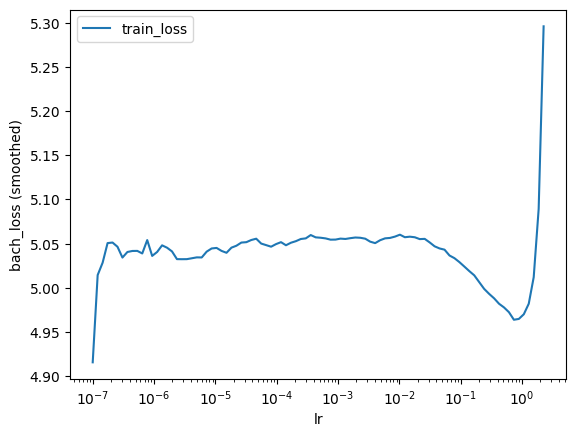

In [ ]:
# Define batch size
batch_size = 256

# Use learning rate finder to identify a suitable initial learning rate
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=10)
_ = lrfinder.plot()

In [ ]:
lrfinder.get_best_lr()

0.0001

In [ ]:
model.optimizer is optimizer

False

In [ ]:
# Redefine the model and optimizer because lr_finder modifies the model state
net = nn.Linear(x_train.shape[1], 1)
optimizer = tt.optim.SGD()

# Create a new CoxPH model instance using the updated network and optimizer
model = CoxPH(net, optimizer)

In [ ]:
model.optimizer.set_lr(0.01)

In [ ]:
# Set maximum number of training epochs
epochs = 100

# Apply early stopping to avoid overfitting and save training time
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [ ]:
batch_size

256

In [ ]:
# Train the CoxPH neural network model using the training data
# Validation data is also provided to monitor performance and apply early stopping
# %%time is used to measure the execution time of the training process
%%time
log = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=True, val_data=(x_val, y_val), val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.7808,	val_loss: 4.6986
1:	[0s / 0s],		train_loss: 4.7029,	val_loss: 4.6700
2:	[0s / 1s],		train_loss: 4.6864,	val_loss: 4.6562
3:	[0s / 1s],		train_loss: 4.6777,	val_loss: 4.6473
4:	[0s / 1s],		train_loss: 4.6688,	val_loss: 4.6397
5:	[0s / 2s],		train_loss: 4.6631,	val_loss: 4.6335
6:	[0s / 2s],		train_loss: 4.6575,	val_loss: 4.6291
7:	[0s / 3s],		train_loss: 4.6538,	val_loss: 4.6246
8:	[0s / 3s],		train_loss: 4.6497,	val_loss: 4.6205
9:	[0s / 3s],		train_loss: 4.6471,	val_loss: 4.6164
10:	[0s / 4s],		train_loss: 4.6436,	val_loss: 4.6135
11:	[0s / 4s],		train_loss: 4.6415,	val_loss: 4.6109
12:	[0s / 4s],		train_loss: 4.6401,	val_loss: 4.6083
13:	[0s / 4s],		train_loss: 4.6372,	val_loss: 4.6060
14:	[0s / 5s],		train_loss: 4.6354,	val_loss: 4.6043
15:	[0s / 5s],		train_loss: 4.6342,	val_loss: 4.6027
16:	[0s / 5s],		train_loss: 4.6336,	val_loss: 4.6012
17:	[0s / 5s],		train_loss: 4.6321,	val_loss: 4.6002
18:	[0s / 6s],		train_loss: 4.6310,	val_loss: 4.5982
19:

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


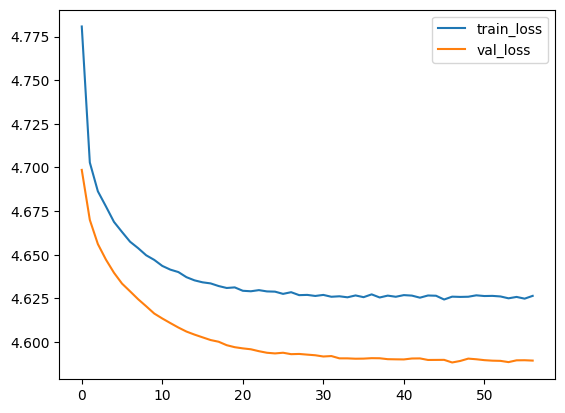

In [ ]:
_ = log.plot()

In [ ]:
model.partial_log_likelihood(*(x_val, y_val)).mean()

-9.682436

In [ ]:
baseline = model.compute_baseline_hazards()
baseline

,baseline_hazards
duration,
0.100000,0.002549
0.200000,0.002252
0.300000,0.002471
0.400000,0.002380
0.500000,0.002879
...,...
99.599998,0.000877
99.699997,0.001757
99.800003,0.000881


In [ ]:
param = model.net.parameters()
for parameters in param:
  print(parameters.data)

tensor([[ 2.0023e-02, -6.8630e-03, -3.4558e-04,  1.6586e-02, -6.6612e-03,
         -1.2360e-01,  1.3320e-01,  1.2527e-01, -1.3254e-01, -1.0540e-01,
          1.2306e-01, -1.2444e-01, -1.4211e-01, -1.4281e-01, -1.0668e-01,
         -2.4565e-01,  2.3848e-01, -2.0840e-01, -2.1112e-01,  1.4170e-01,
         -1.5641e-01,  1.5216e-01, -1.4875e-01, -1.2565e-01, -8.6151e-02,
         -3.0079e-02, -3.5190e-02, -3.6358e-02,  3.2712e-02,  3.6020e-02,
         -6.6397e-01,  6.6224e-01,  6.5813e-01,  6.7149e-01,  4.7298e-01,
          2.8723e-01, -2.9071e-01, -2.7931e-01, -2.5986e-01,  1.8443e-01,
          4.4721e-01, -4.5206e-01,  4.4732e-01, -4.3562e-01, -3.0739e-01]])
tensor([-0.0210])


In [ ]:
surv = model.predict_surv_df(x_test)

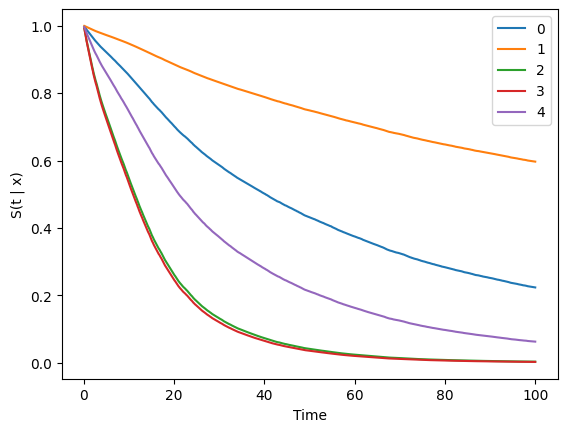

In [ ]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
from eval_surv import EvalSurv
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [ ]:
ev.concordance_td()

0.6797710046828951

Simulated dataset with 10,000 samples is preprocessed for training, validation, and testing.


NEWTON

In [ ]:
# Preprocessing the data with size 10,000
# This is a smaller subset to test performance or generalization
size = 10000

# Preprocessing data
data_10, data_train_10, x_train_df_10, x_train_10, x_val_10, x_test_10, y_train_10, y_val_10, durations_test_10, events_test_10, data_test_10 = preprocess_data(size)

In [ ]:
# Fit Cox Proportional Hazards model (lifelines) on dataset of size 10,000
cph_10 = CoxPHFitter()
cph_10.fit(x_train_df_10, duration_col='duration', event_col='event', show_progress=True)

Iteration 1: norm_delta = 2.05e+00, step_size = 0.9500, log_lik = -41751.63268, newton_decrement = 1.01e+03, seconds_since_start = 0.3
Iteration 2: norm_delta = 1.43e-01, step_size = 0.9500, log_lik = -40744.82598, newton_decrement = 5.33e+00, seconds_since_start = 0.7
Iteration 3: norm_delta = 8.00e-03, step_size = 0.9500, log_lik = -40739.49163, newton_decrement = 1.62e-02, seconds_since_start = 0.9
Iteration 4: norm_delta = 2.82e-06, step_size = 1.0000, log_lik = -40739.47539, newton_decrement = 1.91e-09, seconds_since_start = 1.3
Convergence success after 4 iterations.


<lifelines.CoxPHFitter: fitted with 8000 total observations, 2949 right-censored observations>

In [ ]:
cph_10.print_summary()

<lifelines.CoxPHFitter: fitted with 8000 total observations, 2949 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 8000
number of events observed = 5051
   partial log-likelihood = -40739.48
         time fit was run = 2024-09-25 18:19:54 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
x0         0.01      1.01      0.02           -0.03            0.05                0.97                1.05
x1         0.03      1.03      0.03           -0.03            0.08                0.97                1.09
x2        -0.01      0.99      0.04           -0.08            0.06                0.92                1.06
x3         0.01      1.01      0.04           -0.07            0.09                0.93                1.09
x4         0.01      1.01      0.03           -0.05            0.07                0.95                1.07
x5        -0.17      0.84      0.02           -0.21           -0.13                0.81                0.88
x6         0.21      1.23      0.03            0.15            0.27                1.16                1.30
x7         0.19      1.21      0.04            0.12            0.26                1.13                1.30
x8        -0.21      0.81      0.04           -0.29           -0.13                0.75                0.88
x9        -0.16      0.85      0.03           -0.22           -0.10                0.80                0.91
x10        0.12      1.13      0.02            0.08            0.16                1.09                1.17
x11       -0.13      0.88      0.03           -0.18           -0.07                0.83                0.93
x12       -0.14      0.87      0.03           -0.21           -0.08                0.81                0.93
x13        0.16      1.17      0.04            0.08            0.23                1.09                1.26
x14       -0.13      0.88      0.03           -0.19           -0.07                0.83                0.93
x15       -0.25      0.78      0.02           -0.29           -0.21                0.75                0.81
x16        0.24      1.28      0.03            0.19            0.30                1.21                1.35
x17        0.25      1.28      0.03            0.18            0.32                1.20                1.37
x18       -0.23      0.79      0.04           -0.31           -0.16                0.73                0.85
x19        0.17      1.18      0.03            0.11            0.23                1.11                1.26
x20        0.16      1.18      0.02            0.12            0.20                1.13                1.22
x21        0.14      1.15      0.03            0.08            0.19                1.08                1.21
x22        0.15      1.16      0.03            0.08            0.22                1.09                1.25
x23       -0.16      0.85      0.04           -0.24           -0.08                0.79                0.92
x24        0.12      1.13      0.03            0.06            0.18                1.06                1.20
x25        0.00      1.00      0.02           -0.04            0.04                0.96                1.04
x26        0.02      1.02      0.03           -0.03            0.08                0.97                1.08
x27        0.03      1.03      0.03           -0.04            0.10                0.96                1.11
x28       -0.04      0.96      0.04           -0.12            0.04                0.89                1.04
x29       -0.03      0.97      0.03           -0.09            0.03                0.91                1.03
x30        0.69      2.00      0.02            0.65            0.74                1.92                2.09
x31       -0.70      0.49      0.03           -0.76           -0.65  

In [ ]:
surv_lifelines_10 = cph_10.predict_survival_function(x_test_10)
c_index_lifelines_10 = concordance_index(durations_test_10, -cph_10.predict_partial_hazard(x_test_10), events_test_10)
likelihood_newton_10 = cph_10.log_likelihood_

In [ ]:
likelihood_newton_10

-40739.47538632105

In [ ]:
c_index_lifelines_10

0.674816611926805

SGD

In [ ]:
# Define Cox Proportional Hazards model (PyCox) for dataset of size 10,000
net = nn.Linear(x_train.shape[1], 1)
optimizer = tt.optim.SGD()
model_10 = CoxPH(net, optimizer=optimizer)

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


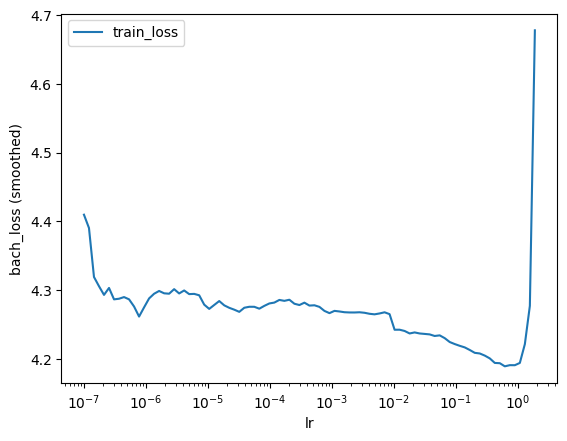

In [ ]:
# Find the optimal learning rate using learning rate finder
batch_size = 128
lrfinder = model_10.lr_finder(x_train_10, y_train_10, batch_size, tolerance=10)
_ = lrfinder.plot()

In [ ]:
lrfinder.get_best_lr()

0.0613590727341321

In [ ]:
model_10 is optimizer

False

In [ ]:
# Define the Cox Proportional Hazards model with a linear layer
net = nn.Linear(x_train.shape[1], 1)
optimizer = tt.optim.SGD()
model_10 = CoxPH(net, optimizer=optimizer)

In [ ]:
model_10.optimizer.set_lr(0.01)

In [ ]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [ ]:
batch_size

128

In [ ]:
%%time
log = model_10.fit(x_train_10, y_train_10, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=True, val_data=(x_val_10, y_val_10), val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 4.0929,	val_loss: 4.1008
1:	[0s / 0s],		train_loss: 4.0375,	val_loss: 4.0627
2:	[0s / 0s],		train_loss: 4.0142,	val_loss: 4.0445
3:	[0s / 0s],		train_loss: 4.0009,	val_loss: 4.0334
4:	[0s / 1s],		train_loss: 3.9942,	val_loss: 4.0252
5:	[0s / 1s],		train_loss: 3.9879,	val_loss: 4.0194
6:	[0s / 1s],		train_loss: 3.9834,	val_loss: 4.0152
7:	[0s / 1s],		train_loss: 3.9803,	val_loss: 4.0116
8:	[0s / 1s],		train_loss: 3.9779,	val_loss: 4.0060
9:	[0s / 2s],		train_loss: 3.9754,	val_loss: 4.0045
10:	[0s / 2s],		train_loss: 3.9740,	val_loss: 4.0006
11:	[0s / 2s],		train_loss: 3.9704,	val_loss: 3.9975
12:	[0s / 2s],		train_loss: 3.9674,	val_loss: 3.9950
13:	[0s / 2s],		train_loss: 3.9662,	val_loss: 3.9928
14:	[0s / 3s],		train_loss: 3.9617,	val_loss: 3.9912
15:	[0s / 3s],		train_loss: 3.9615,	val_loss: 3.9884
16:	[0s / 3s],		train_loss: 3.9584,	val_loss: 3.9878
17:	[0s / 3s],		train_loss: 3.9581,	val_loss: 3.9862
18:	[0s / 3s],		train_loss: 3.9566,	val_loss: 3.9831
19:

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


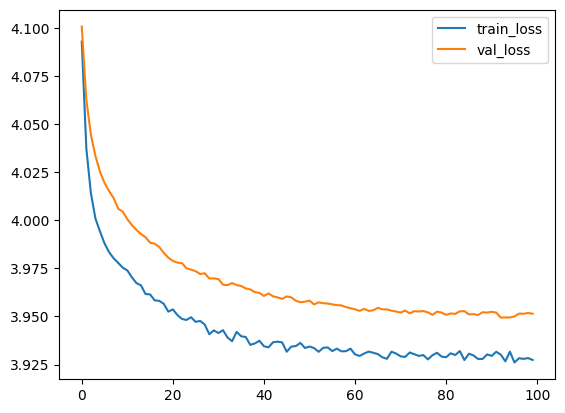

In [ ]:
_ = log.plot()

In [ ]:
model_10.partial_log_likelihood(*(x_val_10, y_val_10)).mean()

-6.023563

In [ ]:
baseline = model_10.compute_baseline_hazards()
baseline

,baseline_hazards
duration,
0.100000,0.003322
0.200000,0.002998
0.300000,0.003366
0.400000,0.002924
0.500000,0.002704
...,...
99.400002,0.000000
99.599998,0.002490
99.699997,0.002502


In [ ]:
surv = model_10.predict_surv_df(x_test_10)

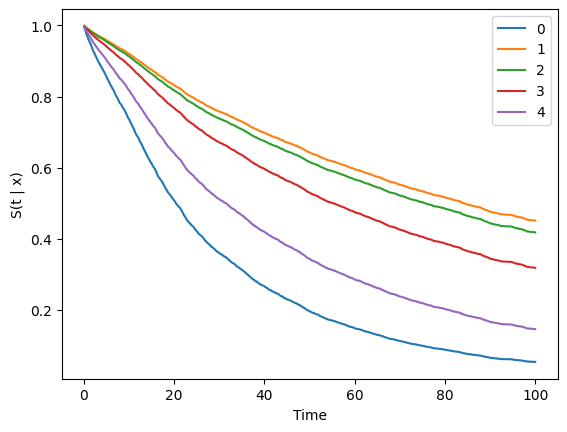

In [ ]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
from eval_surv import EvalSurv
ev = EvalSurv(surv, durations_test_10, events_test_10, censor_surv='km')

In [ ]:
ev.concordance_td()

0.6839154903793613

Preprocessing data with size = 100,000 to simulate survival dataset. This includes splitting into training, validation, and test sets, followed by standardization using `StandardScaler`.


In [ ]:
size = 100000

# Preprocess simulated data for size = 100,000
data_100, data_train_100, x_train_df_100, x_train_100, x_val_100, x_test_100, y_train_100, y_val_100, durations_test_100, events_test_100, data_test_100 = preprocess_data(size)

Fitting Cox Proportional Hazards model from `lifelines` on the training data with 100,000 samples using Newton-Raphson optimization method.


NEWTON

In [ ]:
cph_100 = CoxPHFitter()
cph_100.fit(data_train_100, duration_col='duration', event_col='event', show_progress=True)

In [ ]:
cph_100.print_summary()

In [ ]:
# Evaluasi C-Index
surv_lifelines_100 = cph_100.predict_survival_function(x_test_100)
c_index_lifelines_100 = concordance_index(durations_test_100, -cph_100.predict_partial_hazard(x_test_100), events_test_100)
likelihood_newton_100 = cph_100.log_likelihood_

In [ ]:
likelihood_newton_100

In [ ]:
c_index_lifelines_100

SGD

In [ ]:
#Define CoxPH Model
net = nn.Linear(x_train.shape[1], 1)
optimizer = tt.optim.SGD()
model_100 = CoxPH(net, optimizer=optimizer)

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


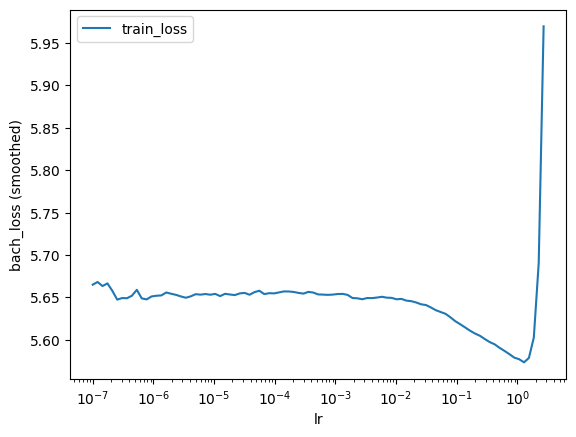

In [ ]:
# Mencari lr terbaik
batch_size = 512
lrfinder = model_100.lr_finder(x_train_100, y_train_100, batch_size, tolerance=10)
_ = lrfinder.plot()

In [ ]:
lrfinder.get_best_lr()

0.12915496650148922

In [ ]:
model_100 is optimizer

False

In [ ]:
#Define CoxPH Model
net = nn.Linear(x_train.shape[1], 1)
optimizer = tt.optim.SGD()
model_100 = CoxPH(net, optimizer=optimizer)

In [ ]:
model_100.optimizer.set_lr(0.1)

In [ ]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [ ]:
batch_size

512

In [ ]:
%%time
log = model_100.fit(x_train_100, y_train_100, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=True, val_data=(x_val_100, y_val_100), val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 5.3655,	val_loss: 5.3182
1:	[0s / 0s],		train_loss: 5.3250,	val_loss: 5.3040
2:	[0s / 1s],		train_loss: 5.3177,	val_loss: 5.2967
3:	[0s / 1s],		train_loss: 5.3160,	val_loss: 5.3009
4:	[0s / 2s],		train_loss: 5.3163,	val_loss: 5.2961
5:	[0s / 2s],		train_loss: 5.3155,	val_loss: 5.2991
6:	[0s / 3s],		train_loss: 5.3160,	val_loss: 5.2982
7:	[0s / 3s],		train_loss: 5.3152,	val_loss: 5.2954
8:	[0s / 4s],		train_loss: 5.3156,	val_loss: 5.2946
9:	[0s / 4s],		train_loss: 5.3158,	val_loss: 5.2977
10:	[0s / 5s],		train_loss: 5.3159,	val_loss: 5.2999
11:	[0s / 5s],		train_loss: 5.3161,	val_loss: 5.2948
12:	[0s / 5s],		train_loss: 5.3159,	val_loss: 5.2984
13:	[0s / 6s],		train_loss: 5.3161,	val_loss: 5.2960
14:	[0s / 6s],		train_loss: 5.3158,	val_loss: 5.2987
15:	[0s / 7s],		train_loss: 5.3154,	val_loss: 5.2999
16:	[0s / 7s],		train_loss: 5.3162,	val_loss: 5.2965
17:	[0s / 7s],		train_loss: 5.3159,	val_loss: 5.2985
18:	[0s / 7s],		train_loss: 5.3166,	val_loss: 5.2965
CPU

/usr/local/lib/python3.10/dist-packages/torchtuples/base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwargs))


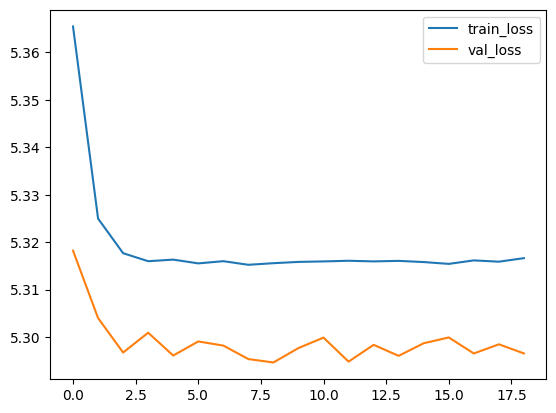

In [ ]:
_ = log.plot()

In [ ]:
model_100.partial_log_likelihood(*(x_val_100, y_val_100)).mean()

-8.295629

In [ ]:
baseline = model_100.compute_baseline_hazards()
baseline

,baseline_hazards
duration,
0.100000,0.002438
0.200000,0.002253
0.300000,0.002539
0.400000,0.002640
0.500000,0.002333
...,...
99.599998,0.001898
99.699997,0.001664
99.800003,0.002382


In [ ]:
surv = model_100.predict_surv_df(x_test_100)

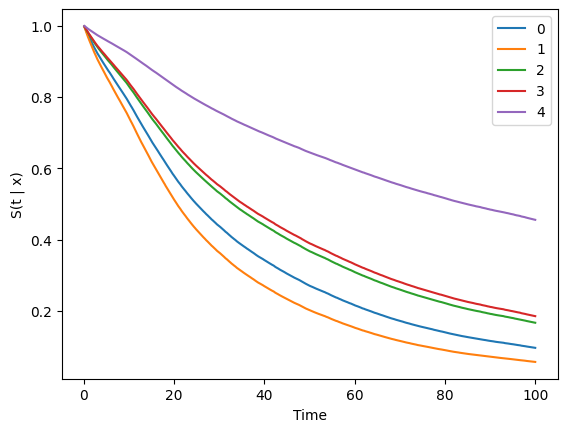

In [ ]:
surv.iloc[:, :5].plot()
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [ ]:
from eval_surv import EvalSurv
ev = EvalSurv(surv, durations_test_100, events_test_100, censor_surv='km')

In [ ]:
ev.concordance_td()

0.6845326020646221

### 📊 Comparison of C-Index Between Newton-Raphson and SGD

This visualization compares the performance of the Cox Proportional Hazards model trained using two different optimization methods: **Newton-Raphson** and **Stochastic Gradient Descent (SGD)**. The performance is measured using the **C-Index** across three different dataset sizes: 10,000, 50,000, and 100,000 observations.


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


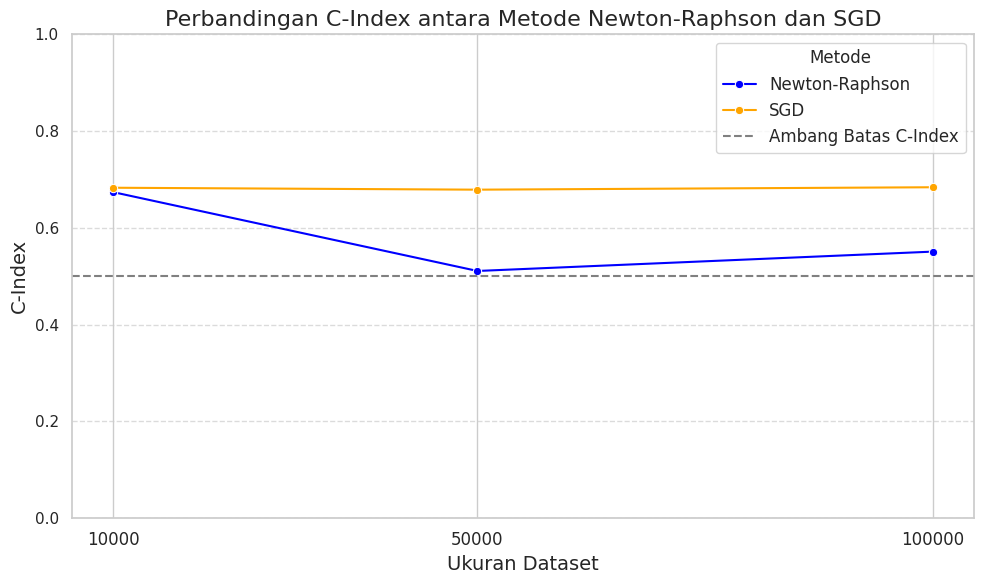

In [ ]:
# Load necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data from evaluation results
data = {
    'Ukuran Dataset': [10000, 10000, 50000, 50000, 100000, 100000],
    'Metode': ['Newton-Raphson', 'SGD', 'Newton-Raphson', 'SGD', 'Newton-Raphson', 'SGD'],
    'C-Index': [0.674, 0.683, 0.511, 0.679, 0.551, 0.684]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set seaborn style
sns.set_theme(style="whitegrid")

# Create line plot
plt.figure(figsize=(10, 6))
line_plot = sns.lineplot(data=df,
                         x='Ukuran Dataset',
                         y='C-Index',
                         hue='Metode',
                         marker='o',
                         palette=['blue', 'orange'],
                         markers=["o", "s"],
                         dashes=False)

# Add horizontal threshold line
plt.axhline(y=0.5, color='gray', linestyle='--', label='Ambang Batas C-Index')

# Customize plot
plt.title('Perbandingan C-Index antara Metode Newton-Raphson dan SGD', fontsize=16)
plt.xlabel('Ukuran Dataset', fontsize=14)
plt.ylabel('C-Index', fontsize=14)
plt.xticks(df['Ukuran Dataset'].unique(), fontsize=12)
plt.ylim(0, 1)  # Menetapkan batas y dari 0 hingga 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Metode', fontsize=12)
plt.tight_layout()
plt.show()
